In [598]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import display, clear_output
import os, sys
os.getcwd()

'/Users/panxingnan/QuickTourForDeepLearning/Example/Logistic Regression'

# 一、配置学习环境  

![配置学习环境](./sources/0.procedure.png) 

## 1. 界定任务  

应用领域：结构化数据  

结果类型：2分类  

![界定任务](./sources/1.task.png)  

In [599]:
path_data = './data/new_database_results.xls'
data = pd.read_excel(path_data, sheet_name='results')
data.iloc[0:3, 1:].round(1)

,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class,ClassName1,ClassName2
0,803.5,27804.1,0.0,85.9,192.5,29.8,34.8,0.9,0.8,181.6,...,101.4,673.5,0.2,44,37,649,655,1,normal_superficiel,normal
1,610.1,18067.9,0.0,81.5,153.4,25.3,30.8,0.8,0.8,171.1,...,85.2,597.0,0.0,36,26,502,504,1,normal_superficiel,normal
2,990.4,79029.9,0.0,77.8,118.0,33.6,38.3,0.9,0.9,290.3,...,111.8,1059.1,0.1,53,37,2267,2500,1,normal_superficiel,normal


Kerne_A：核面积  
Cyto_A：浆面积  
K/C：核浆比  
Kerne_Ycol：核颜色  
Cyto_Ycol：浆颜色  
KerneShort：核短轴  
KerneLong：核长轴  
KerneRund：核圆度  
CytoShort：浆短轴  
CytoLong：浆长轴  
CytoRund：浆圆度  

## 2. 准备数据

数据标注：强监督

![准备数据](./sources/2.data1.png)  
  
  
数据集：只生成训练集和测试集  

![准备数据](./sources/2.data2.png)  

### 2-1. 采集数据

### 2-2. 检查、清洗数据  

- 唯一性  

- 一致性  

- 完整性  

- 准确性  

### 2-3. 预处理数据  

- 去掉不必要的列  

- 生成分类标签  

- 将特征归一化  


In [601]:
# 去掉不必要的列
df = data.drop(['ID', 'ClassName1', 'ClassName2'], axis=1)

In [602]:
# 生成分类标签
bins = [0, 3, 7]
df['label'] = pd.cut(df['Class'], bins=bins, labels=[0, 1])
print('2分类标签')
df[['Class', 'label']].drop_duplicates()

2分类标签


,Class,label
0,1,0
74,2,0
144,3,0
242,4,1
424,5,1
570,6,1
767,7,1


In [603]:
# 将特征归一化
label = df['label']
feature = df.drop(['Class', 'label'], axis=1)

print('归一化前数值')
feature.head(3)

归一化前数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,CytoLong,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin
0,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,181.574886,242.043385,0.750175,0.604273,101.375,673.500,0.230067,44,37,649,655
1,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,171.108766,197.570241,0.866065,0.589351,85.250,597.000,0.043701,36,26,502,504
2,990.375,79029.875,0.012377,77.843655,118.001177,33.552901,38.327536,0.875425,0.858397,290.250246,355.803316,0.815760,0.794843,111.750,1059.125,0.141150,53,37,2267,2500


In [604]:
feature = (feature - feature.mean())/feature.std()
print('归一化后数值')
feature.head(3)

归一化后数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,CytoLong,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin
0,-1.164601,0.675432,-1.539731,-0.212305,2.125615,-1.208496,-1.564634,0.678200,0.891219,0.882348,0.781148,0.328428,1.291274,-1.471815,0.667500,-0.268492,-1.111085,-0.905485,0.366248,0.372045
1,-1.267560,0.197172,-1.518272,-0.411325,0.563027,-1.449092,-1.737695,0.456926,0.730725,0.736792,0.288009,0.981822,1.204862,-1.709653,0.389174,-1.397596,-1.250199,-1.106092,0.134320,0.129158
2,-1.065103,3.191719,-1.613363,-0.580639,-0.853791,-1.010109,-1.414071,0.798760,0.988172,2.393732,2.042572,0.698200,2.394885,-1.318787,2.070500,-0.807197,-0.954583,-0.905485,2.919033,3.339759


### 2-4. 划分训练集和测试集

In [605]:
feature['label'] = label
df_preprocess = feature

df_train = df_preprocess.sample(frac=0.8, axis=0)
df_test = df_preprocess[~df_preprocess.index.isin(df_train.index)]

print('训练集占80%数据')
print(df_train['label'].value_counts())
print('测试集占20%数据')
print(df_test['label'].value_counts())

训练集占80%数据
1    542
0    192
Name: label, dtype: int64
测试集占20%数据
1    133
0     50
Name: label, dtype: int64


In [606]:
class MyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        feature = df.iloc[:, 0:(-1)].values
        label = df.iloc[:, -1].values

        self.feature = torch.tensor(feature, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        return self.feature[index], self.label[index]

ds_train = MyDataset(df_train)
ds_test = MyDataset(df_test)

## 3. 定义模型结构  

模型：Logistics（只有一个神经元的神经网络）  

![定义模型结构](./sources/3.model.png) 

In [607]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()

        # 线性层
        self.linear = nn.Linear(input_dim, 1)
        
        # 激活函数
        self.activation_function = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation_function(x)
        return x

LR = LogisticRegression(df_train.shape[1] - 1)

## 4. 选择目标函数

目标函数：交叉熵损失  

![选择目标函数](./sources/4.obj_function.png) 

In [608]:
loss_function = torch.nn.BCELoss()

## 5. 选择优化器

优化器：随机梯度下降  

学习率：0.01  

![选择优化器](./sources/5.optimization.png) 

In [609]:
learning_rate=0.1
optimizer = torch.optim.SGD(LR.parameters(), lr=learning_rate)

# 二、学习过程

![学习过程](./sources/0.procedure.png) 

### a. 初始化权重
将权重全部初始化为 1, 将偏置初始化为 0

In [610]:
nn.init.constant_(LR.linear.weight, 1)
nn.init.constant_(LR.linear.bias, 0)
LR.linear.weight.squeeze().detach().numpy(), LR.linear.bias.squeeze().detach().numpy()

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], dtype=float32),
 array(0., dtype=float32))

In [611]:
def get_round_weight(vector, lr=None):
    '''
    与模型无关
    用于获取核浆比, 核颜色和核圆度相关向量的输出字符串, 小数取 4 位
    '''
    lr = 1 if lr is None else -lr
    result = vector[:, [2, 3, 9]].squeeze() * lr
    result = result.detach().tolist()
    result = ['{:.4f}'.format(x) for x in result]
    return result

## 1. 第一个循环
我们选出三个比较关键的参数`核浆比, 核颜色和核圆度`, 并观察他们的权重变化

### a. 预测结果
首先我们将特征数据输入模型, 然后直接让模型预测结果. 打印前10条记录的`预测结果`

In [612]:
LR.train(True)
outputs = LR(ds_train.feature)
outputs[:10]

tensor([[4.3282e-05],
        [3.8824e-01],
        [1.4641e-01],
        [4.7256e-02],
        [2.4841e-02],
        [9.9236e-01],
        [2.0974e-02],
        [8.7013e-03],
        [8.1735e-01],
        [9.8497e-01]], grad_fn=<SliceBackward>)

### b. 计算损失值
然后我们通过`损失函数`去计算和衡量`预测结果与真实情况`之间差距

In [613]:
loss = loss_function(outputs.squeeze(), ds_train.label)
loss

tensor(3.4953, grad_fn=<BinaryCrossEntropyBackward>)

### c. 计算权重梯度
当我们有损失值后, 我们需要通过`反向传播`的方式更新特征对应的系数值.

In [614]:
optimizer.zero_grad()
loss.backward()
cur_grad = get_round_weight(LR.linear.weight.grad)
print('当前梯度是: {}'.format(cur_grad))

当前梯度是: ['-0.3521', '-0.0515', '0.4476']


### d. 更新权重
我们用上面获得的梯度, 更新权重
```
新权重值 = 老权重值 + (学习率 * 梯度)
```

In [615]:
last_weight=get_round_weight(LR.linear.weight)
cur_update =get_round_weight(LR.linear.weight.grad, lr=learning_rate)
optimizer.step()
cur_weight=get_round_weight(LR.linear.weight)
print('''当前循环次数 1:
  之前的权重 : {}
  当前学习率 : {}
  学习率*梯度: {}
  更新后权重 : {} '''.format(last_weight, learning_rate, cur_update, cur_weight))

当前循环次数 1:
  之前的权重 : ['1.0000', '1.0000', '1.0000']
  当前学习率 : 0.1
  学习率*梯度: ['0.0352', '0.0052', '-0.0448']
  更新后权重 : ['1.0352', '1.0052', '0.9552'] 


## 2. 第二个循环
重复上面第一个循环

### a. 预测结果

In [616]:
LR.train(True)
outputs = LR(ds_train.feature)
outputs[:10]

tensor([[5.5573e-05],
        [2.8375e-01],
        [1.7817e-01],
        [3.2371e-02],
        [2.8932e-02],
        [9.9210e-01],
        [2.5952e-02],
        [9.7919e-03],
        [8.4851e-01],
        [9.8591e-01]], grad_fn=<SliceBackward>)

### b. 计算损失

In [617]:
loss = loss_function(outputs.squeeze(), ds_train.label)
loss

tensor(3.2287, grad_fn=<BinaryCrossEntropyBackward>)

### c. 计算权重梯度

In [618]:
optimizer.zero_grad()
loss.backward()
cur_grad = get_round_weight(LR.linear.weight.grad)
print('当前梯度是: {}'.format(cur_grad))

当前梯度是: ['-0.3428', '-0.0428', '0.4419']


### d. 更新权重

In [619]:
last_weight=get_round_weight(LR.linear.weight)
cur_update =get_round_weight(LR.linear.weight.grad, lr=learning_rate)
optimizer.step()
cur_weight=get_round_weight(LR.linear.weight)
print('''当前循环次数 2:
  之前的权重 : {}
  当前学习率 : {}
  学习率*梯度: {}
  更新后权重 : {} '''.format(last_weight, learning_rate, cur_update, cur_weight))

当前循环次数 2:
  之前的权重 : ['1.0352', '1.0052', '0.9552']
  当前学习率 : 0.1
  学习率*梯度: ['0.0343', '0.0043', '-0.0442']
  更新后权重 : ['1.0695', '1.0094', '0.9110'] 


## 3. 全部循环
观察`核浆比, 核颜色和核圆度`权重变化

### 设置迭代次数

In [620]:
epoches = 100

In [621]:
losses_train = []
losses_test = []
weights = None
predictions = []

for epoch in range(epoches):
    # 开始训练
    LR.train(True)
    last_weight = get_round_weight(LR.linear.weight)
    
    ## 获取数据
    inputs, labels = ds_train.feature, ds_train.label
    optimizer.zero_grad()

    ## 预测结果
    outputs = LR(inputs)
    outputs = outputs.squeeze(-1)

    ## 计算损失
    loss = loss_function(outputs, labels)

    ## 计算权重梯度
    loss.backward()
    cur_grad = get_round_weight(LR.linear.weight.grad, lr=learning_rate)
    
    ## 改变权重
    optimizer.step()
    losses_train.append(loss.item())
    cur_weight = get_round_weight(LR.linear.weight)

    # 开始测试
    LR.train(False)
    total = 0
    correct = 0

    inputs, labels = ds_test.feature, ds_test.label
    outputs = LR(inputs)
    outputs = outputs.squeeze(-1)
    loss = loss_function(outputs, labels)
    total += labels.size(0)
    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == labels.detach().numpy())

    losses_test.append(loss.item())
    predictions.append(outputs.detach().numpy())

    # 提取模型权重
    w1 = LR.linear.weight.detach().numpy().squeeze()
    b1 = LR.linear.bias.detach().numpy()
    merge = np.concatenate((w1, b1))
    weights = merge if weights is None else np.vstack((weights, merge))
    
    print('*'*15,
        '''当前循环次数: {:2d} | 准确率: {:.2f}, 训练集/测试集损失值: {:.4f}/{:.4f}
    之前的权重 : {}
    梯度*学习率: {}
    更新后权重 : {}'''.format(epoch+3, correct/total, losses_train[-1], losses_test[-1], last_weight, cur_grad, cur_weight)
    )

    time.sleep(0.5)

*************** 当前循环次数:  3 | 准确率: 0.53, 训练集/测试集损失值: 2.8510/2.6596
    之前的权重 : ['1.0695', '1.0094', '0.9110']
    梯度*学习率: ['0.0335', '0.0035', '-0.0442']
    更新后权重 : ['1.1030', '1.0129', '0.8668']
*************** 当前循环次数:  4 | 准确率: 0.54, 训练集/测试集损失值: 2.7044/2.5022
    之前的权重 : ['1.1030', '1.0129', '0.8668']
    梯度*学习率: ['0.0323', '0.0026', '-0.0432']
    更新后权重 : ['1.1353', '1.0155', '0.8236']
*************** 当前循环次数:  5 | 准确率: 0.54, 训练集/测试集损失值: 2.5645/2.3540
    之前的权重 : ['1.1353', '1.0155', '0.8236']
    梯度*学习率: ['0.0310', '0.0017', '-0.0421']
    更新后权重 : ['1.1663', '1.0172', '0.7816']
*************** 当前循环次数:  6 | 准确率: 0.58, 训练集/测试集损失值: 2.4320/2.2157
    之前的权重 : ['1.1663', '1.0172', '0.7816']
    梯度*学习率: ['0.0297', '0.0008', '-0.0409']
    更新后权重 : ['1.1960', '1.0180', '0.7407']
*************** 当前循环次数:  7 | 准确率: 0.59, 训练集/测试集损失值: 2.3066/2.0867
    之前的权重 : ['1.1960', '1.0180', '0.7407']
    梯度*学习率: ['0.0284', '-0.0001', '-0.0397']
    更新后权重 : ['1.2244', '1.0180', '0.7010']
*************** 当前循

# 三、结果分析

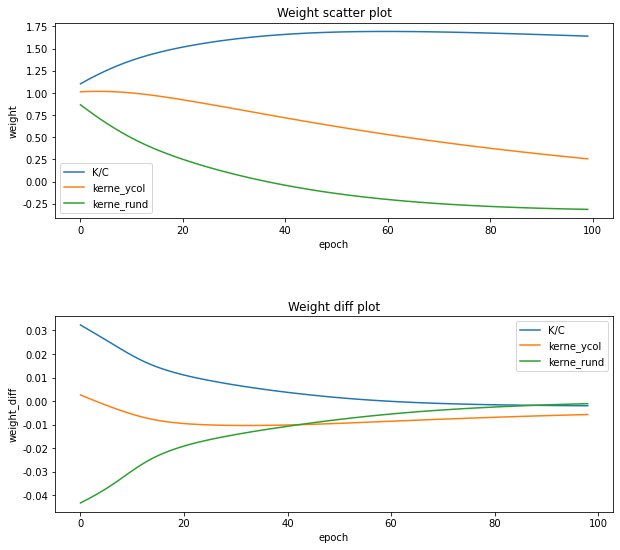

In [640]:
# 可视化权重变化
# FIXME
cols = list(df_train.columns.values)[:-1]
cols.append('bias')
df_weights = pd.DataFrame(weights, columns=cols)
kc, kerne_ycol, kerne_rund = df_weights.iloc[:, 2], df_weights.iloc[:, 3], df_weights.iloc[:, 9]

def calculate_diff(weights):
    result = []
    n = weights.shape[0]
    for i in range(1, n):
        result.append(weights[i] - weights[i-1])
    return result

diff1, diff2, diff3 = calculate_diff(kc), calculate_diff(kerne_ycol), calculate_diff(kerne_rund)
plt.figure(figsize=(10, 9))

# 权重变化图
plt.subplot(2, 1, 1)
x = np.arange(0, epoches)
plt.plot(x, kc, label='K/C')
plt.plot(x, kerne_ycol, label='kerne_ycol')
plt.plot(x, kerne_rund, label='kerne_rund')
plt.title('Weight scatter plot')
plt.xlabel('epoch')
plt.ylabel('weight')
plt.legend()

# 权重差值变化图
plt.subplot(2, 1, 2)
x = np.arange(0,  len(diff1))
plt.plot(x, diff1, label='K/C')
plt.plot(x, diff2, label='kerne_ycol')
plt.plot(x, diff3, label='kerne_rund')
plt.title('Weight diff plot')
plt.xlabel('epoch')
plt.ylabel('weight_diff')
plt.subplots_adjust(hspace=0.5)
plt.legend()
plt.show()

由上图我们可以看出来
- 随着训练的进行, 模型的权重在不断的变化;
- 从第一张图可以看出, 核浆比的系数为正数, 所以核浆比和结果呈正相关, 也就是说核浆比越大, 该细胞为癌细胞概率越大, 核颜色, 核圆度反之,
- 另外随着模型的训练, 模型会最逐渐的收敛, 权重的变化也越来越小, 到最后训练循环间权重的变化都趋近于 0. 

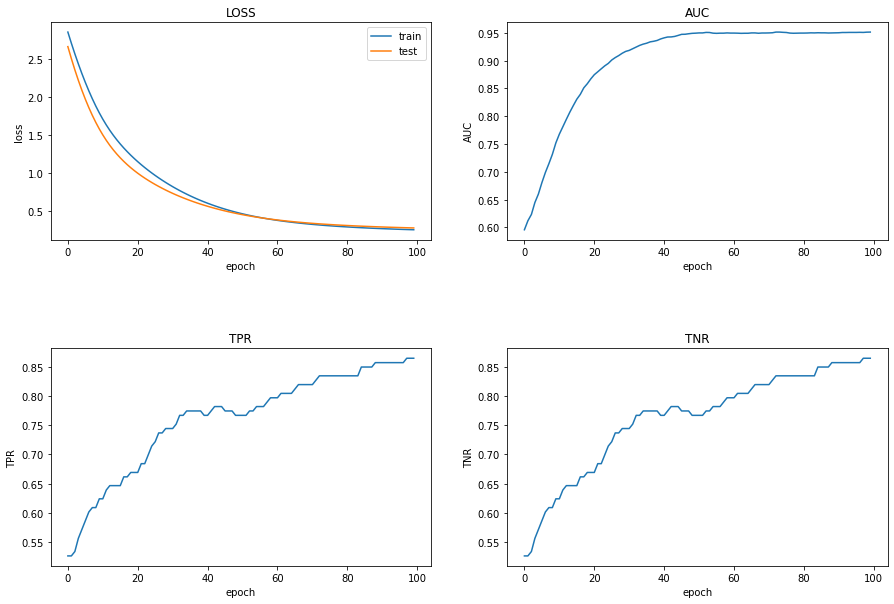

In [642]:
# loss
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
x = np.arange(0, epoches)
plt.plot(x, losses_train, label='train')
plt.plot(x, losses_test, label='test')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# 计算 auc, 真阳率(true positive rate), 真阴率(true negative rate)
from sklearn.metrics import confusion_matrix, roc_auc_score
label_true = df_test['label'].to_numpy()
aucs, tprs, tnrs = [], [], []
theshold = 0.5

for pred in predictions:
    aucs.append(roc_auc_score(label_true, pred))
    tmp = pred.copy()
    tmp[tmp >= theshold] = 1
    tmp[tmp < theshold] = 0
    tn, fp, fn, tp = confusion_matrix(label_true, tmp).ravel()
    tprs.append(tp/(tp+fn))
    tnrs.append(tn/(tn+fp))

# plt.figure(figsize=(10, 18))
tittle = 'AUC TPR TNR'.split()
x = np.arange(0, epoches)
for index, matric in enumerate([aucs, tprs, tprs]):
    plt.subplot(2, 2, index+2)
    plt.plot(x, matric)
    plt.title(tittle[index])
    plt.xlabel('epoch')
    plt.ylabel(tittle[index])
plt.subplots_adjust(hspace=0.5)
plt.show()

由上图我们可以看出
- 模型的损失值在不断的下降. 且训练集和测试集差距不大, 证明模型能能很好的学习;
- 模型其他衡量指标也在随着模型训练的进行, 不断上升. AUC, 真阳率, 真阴率均超过 0.8, 证明模型能很好预测结果